In [2]:
import sys
sys.path.append('src/')
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

# panda view settings
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', 500)  # Display full text in columns

In [3]:
combined_training_bart = pd.read_csv('results/training/bart-large/combined_training_results.csv')
combined_training_debertav3 = pd.read_csv('results/training/debertav3/combined_deberta_trainng_results.csv')

combined_test_bart = pd.read_csv('results/test/bart-large/combined_test_results.csv')
combined_test_debertav3 = pd.read_csv('results/test/debertav3/combined_test_results_deberta.csv')

# Training data analysis

## Test f1 scores

In [4]:
def set_predictions_multiple(df, max_correct_threshold=1):
    def is_bias(row, n_labels):
        labels = ast.literal_eval(row['labels'])
        if sum(label == 'entailment' for label in labels) >= n_labels:
            return 'bias'
        else:
            return 'neutral'

    label_correctness_list = []

    for _, row in df.iterrows():
        row_results = []

        for n in range(1, max_correct_threshold + 1):
            result = is_bias(row, n)
            row_results.append(result)

        label_correctness_list.append(row_results)

    # Add the list as the 'is_label_correct' column in the DataFrame
    df['predicted'] = pd.Series(label_correctness_list)

    return df


In [5]:
df_training_multiple_bart = set_predictions_multiple(combined_training_bart, 15)
df_training_multiple_debertav3 = set_predictions_multiple(combined_training_debertav3, 15)

In [6]:
np.random.seed(42)

In [7]:
def convert_to_binary(label_array, target_label):
    return [1 if label == target_label else 0 for label in label_array]

In [8]:
def calculate_multiple_f1_scores(df):
    f1_score_values = [] 

    for idx in range(len(df['predicted'].iloc[0])):
        predicted_labels = df['predicted'].apply(lambda x: x[idx])
        actual = df['bias']

        # Convert predicted_labels to binary (1 for target_label, 0 otherwise)
        predicted_binary_bias = convert_to_binary(predicted_labels, 'bias')
        actual_binary_bias = convert_to_binary(actual, 'bias')

        predicted_binary_neutral = convert_to_binary(predicted_labels, 'neutral')
        actual_binary_neutral = convert_to_binary(actual, 'neutral')

        f1_bias = f1_score(actual_binary_bias, predicted_binary_bias)
        f1_neutral =  f1_score(actual_binary_neutral, predicted_binary_neutral)

        f1_score_values.append((f1_bias + f1_neutral) / 2)

    return f1_score_values

In [9]:
f1_scores_training_deberta = calculate_multiple_f1_scores(df_training_multiple_debertav3)
print('F1 scores training deberta-v3:')
print(f1_scores_training_deberta)

f1_scores_training_bart = calculate_multiple_f1_scores(df_training_multiple_bart)
print('F1 scores training bart-large:')
print(f1_scores_training_bart)

F1 scores training deberta-v3:
[0.6376965879034648, 0.5720069675190655, 0.4999336700477346, 0.4462344594793496, 0.38593750000000004, 0.35776134304195994, 0.3497735709081982, 0.34454365185701274, 0.34315305713594546, 0.33615436987753483, 0.33615436987753483, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
F1 scores training bart-large:
[0.6246005257162046, 0.6472744365520144, 0.6252075022617292, 0.575503530286139, 0.5267880152894934, 0.4739560545499039, 0.4318651196341896, 0.3915961375073525, 0.3661499709257056, 0.3516009695114172, 0.34117369633956807, 0.337272404633105, 0.3330504879083581, 0.3330504879083581, 0.3333333333333333]


## Check neutral prediction numbers

In [10]:
neutral_rows = df_training_multiple_debertav3[df_training_multiple_debertav3['predicted'].apply(lambda x: all(item == 'neutral' for item in x))]
print(len(neutral_rows))

neutral_rows = df_training_multiple_bart[df_training_multiple_bart['predicted'].apply(lambda x: all(item == 'neutral' for item in x))]
print(len(neutral_rows))

681
371


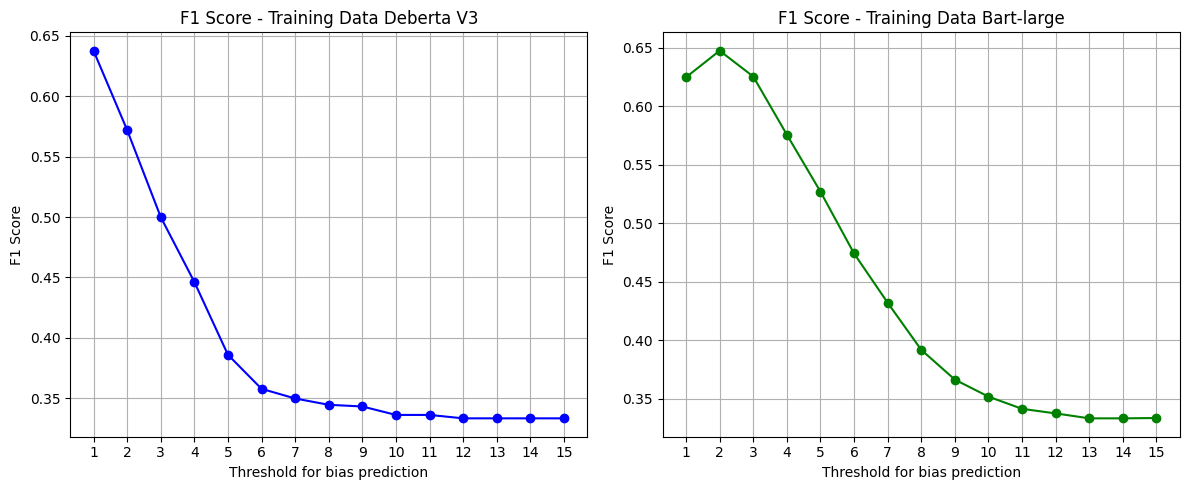

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for training data
plt.subplot(1, 2, 1)
plt.plot(range(1, len(f1_scores_training_deberta) + 1), f1_scores_training_deberta, marker='o', color='blue')
plt.xlabel('Threshold for bias prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score - Training Data Deberta V3')
plt.xticks(range(1, len(f1_scores_training_deberta) + 1))
plt.grid()

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(range(1, len(f1_scores_training_bart) + 1), f1_scores_training_bart, marker='o', color='green')
plt.xlabel('Threshold for bias prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score - Training Data Bart-large')
plt.xticks(range(1, len(f1_scores_training_bart) + 1))
plt.grid()

plt.tight_layout()
plt.show()


## AUC (Area under curve)

In [11]:
def calculate_entailment_ratio(labels):
    labels = ast.literal_eval(labels)
    entailment_count = sum(label == 'entailment' for label in labels) 
    return entailment_count / len(labels)

In [12]:
# Add entailment ratios to df
df_training_multiple_debertav3['entailment_ratio'] = df_training_multiple_debertav3['labels'].apply(calculate_entailment_ratio)
df_training_multiple_bart['entailment_ratio'] = df_training_multiple_bart['labels'].apply(calculate_entailment_ratio)

In [13]:
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_training_multiple_debertav3['predicted']))
positive_class = 'bias'

y_true = (df_training_multiple_debertav3['bias'] == positive_class).astype(int)
y_scores = df_training_multiple_debertav3['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for training data debertav3: {auc_roc}")

AUC-ROC Score for training data debertav3: 0.6509794495270282


In [14]:
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_training_multiple_bart['predicted']))
positive_class = 'bias'

y_true = (df_training_multiple_bart['bias'] == positive_class).astype(int)
y_scores = df_training_multiple_bart['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for training data bart-large: {auc_roc}")

AUC-ROC Score for training data bart-large: 0.6764733018666356


# Test data analysis

In [21]:
df_test_multiple_bart = set_predictions_multiple(combined_test_bart, 2)
df_test_multiple_debertav3 = set_predictions_multiple(combined_test_debertav3, 1)

In [22]:
f1_scores_test_deberta = calculate_multiple_f1_scores(df_test_multiple_debertav3)
print('F1 scores test deberta-v3:')
print(f1_scores_test_deberta)

f1_scores_test_bart = calculate_multiple_f1_scores(df_test_multiple_bart)
print('F1 scores test bart-large:')
print(f1_scores_test_bart)

F1 scores test deberta-v3:
[0.6387497727310293]
F1 scores test bart-large:
[0.6409096012431608, 0.654846494774973]


In [26]:
# Add entailment ratios to df
df_test_multiple_debertav3['entailment_ratio'] = df_test_multiple_debertav3['labels'].apply(calculate_entailment_ratio)
df_test_multiple_bart['entailment_ratio'] = df_test_multiple_bart['labels'].apply(calculate_entailment_ratio)

In [27]:
df_test_multiple_debertav3['entailment_ratio'] = df_test_multiple_debertav3['labels'].apply(calculate_entailment_ratio)
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_test_multiple_debertav3['predicted']))
positive_class = 'bias'

y_true = (df_test_multiple_debertav3['bias'] == positive_class).astype(int)
y_scores = df_test_multiple_debertav3['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for deberta data: {auc_roc}")

AUC-ROC Score for deberta data: 0.6465139049366653


In [29]:
df_test_multiple_bart['entailment_ratio'] = df_test_multiple_bart['labels'].apply(calculate_entailment_ratio)
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_test_multiple_bart['predicted']))
positive_class = 'bias'

y_true = (df_test_multiple_bart['bias'] == positive_class).astype(int)
y_scores = df_test_multiple_bart['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for bart data: {auc_roc}")

AUC-ROC Score for bart data: 0.6873841076638463


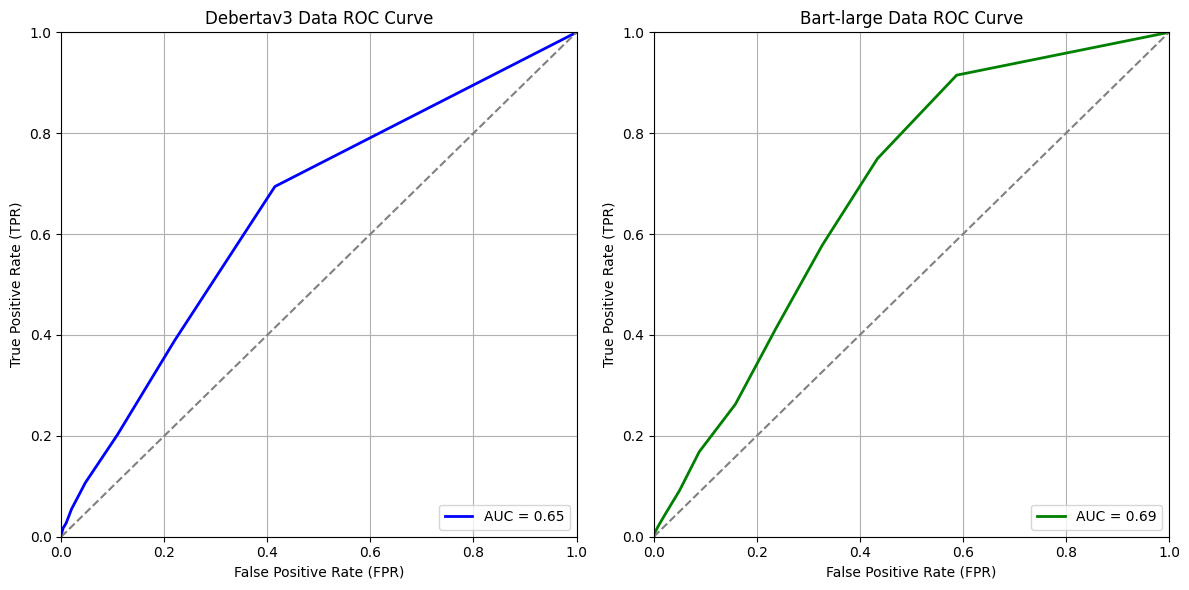

In [33]:
# Convert the true labels to binary values (0 for 'neutral', 1 for 'bias')
y_true_deberta = (df_test_multiple_debertav3['bias'] == 'bias').astype(int)
y_true_bart = (df_test_multiple_bart['bias'] == 'bias').astype(int)

# Get the predicted ratios from the 'entailment_ratio' column
y_scores_deberta = df_test_multiple_debertav3['entailment_ratio']
y_scores_bart = df_test_multiple_bart['entailment_ratio']

# Calculate the ROC curve for training data
fpr_deberta, tpr_deberta, thresholds_train = roc_curve(y_true_deberta, y_scores_deberta)
roc_auc_deberta = auc(fpr_deberta, tpr_deberta)

# Calculate the ROC curve for test data
fpr_bart, tpr_bart, thresholds_train = roc_curve(y_true_bart, y_scores_bart)
roc_auc_bart = auc(fpr_bart, tpr_bart)

# Plot the ROC curves side by side
plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
plt.plot(fpr_deberta, tpr_deberta, color='blue', lw=2, label=f'AUC = {roc_auc_deberta:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Debertav3 Data ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(fpr_bart, tpr_bart, color='green', lw=2, label=f'AUC = {roc_auc_bart:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Bart-large Data ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


# Full deep dive of results 

In [71]:
bart_large_rationale = pd.read_csv('results/rationale/bart-large_rationale_results.csv')
deberta_base_rationale = pd.read_csv('results/rationale/deberta-base_rationale_results.csv')
deberta_v3_rationale = pd.read_csv('results/rationale/deberta-v3_rationale_results.csv')

In [72]:
deberta_results_training = pd.read_csv('results/training/debertav3/combined_deberta_trainng_results.csv')
bart_results_training = pd.read_csv('results/training/bart-large/combined_training_results.csv')

In [73]:
deberta_results = pd.read_csv('results/test/debertav3/combined_test_results_deberta.csv')
bart_results = pd.read_csv('results/test/bart-large/combined_test_results.csv')

# breakdown of accuracy for bart model by category
bart_results_religion = pd.read_csv('results/test/bart-large/religion_test_results.csv')
bart_results_gender = pd.read_csv('results/test/bart-large/gender_test_results.csv')
bart_results_lgbtq = pd.read_csv('results/test/bart-large/lgbtq_test_results.csv')
bart_results_political = pd.read_csv('results/test/bart-large/political_test_results.csv')
bart_results_race = pd.read_csv('results/test/bart-large/race_test_results.csv')

deberta_results_religion = pd.read_csv('results/test/debertav3/religion_labels_deberta_test.csv')
deberta_results_gender = pd.read_csv('results/test/debertav3/gender_labels_deberta_test.csv')
deberta_results_lgbtq = pd.read_csv('results/test/debertav3/lgbtq_labels_deberta_test.csv')
deberta_results_political = pd.read_csv('results/test/debertav3/political_labels_deberta_test.csv')
deberta_results_race = pd.read_csv('results/test/debertav3/race_labels_deberta_test.csv')
# fine tuned 
bart_results_fine_tuned = pd.read_csv('results/fine_tuning/bart-large/fine_tuning_religion_test_results.csv')



In [74]:
## Set predicted labels 
deberta_results_training = set_predictions_multiple(deberta_results_training, 15)
bart_results_training = set_predictions_multiple(bart_results_training, 15)

In [75]:
## Set predicted labels 
deberta_results = set_predictions_multiple(deberta_results, 15)
bart_results = set_predictions_multiple(bart_results, 15)

bart_results_religion = set_predictions_multiple(bart_results_religion, 15)
bart_results_gender= set_predictions_multiple(bart_results_gender, 15)
bart_results_lgbtq = set_predictions_multiple(bart_results_lgbtq, 15)
bart_results_political = set_predictions_multiple(bart_results_political, 15)
bart_results_race = set_predictions_multiple(bart_results_race, 15)

deberta_results_religion = set_predictions_multiple(deberta_results_religion, 15)
deberta_results_gender = set_predictions_multiple(deberta_results_gender, 15)
deberta_results_lgbtq = set_predictions_multiple(deberta_results_lgbtq, 15)
deberta_results_political = set_predictions_multiple(deberta_results_political, 15)
deberta_results_race = set_predictions_multiple(deberta_results_race, 15)

bart_results_fine_tuned = set_predictions_multiple(bart_results_fine_tuned, 15)

In [76]:

def get_accuracy_results(df, threshold=1):

  # lower threshold for indexing issues
  threshold = threshold - 1

  true_positive_bias = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold] and row['bias'] == 'bias', axis=1)])
  false_positive_bias = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold] and row['bias'] == 'neutral', axis=1)])
  false_negative_bias = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold] and row['bias'] == 'bias', axis=1)])

  precision_bias = true_positive_bias / (true_positive_bias + false_positive_bias + 1e-10)  # Adding a small constant
  recall_bias = true_positive_bias / (true_positive_bias + false_negative_bias + 1e-10)  # Adding a small constant
  f1_bias = (2 * precision_bias * recall_bias) / (precision_bias + recall_bias + 1e-10)  # Adding a small constant

  true_positive_neutral = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold] and row['bias'] == 'neutral', axis=1)])
  false_positive_neutral = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold] and row['bias'] == 'bias', axis=1)])
  false_negative_neutral = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold] and row['bias'] == 'neutral', axis=1)])


  precision_neutral = true_positive_neutral / (true_positive_neutral + false_positive_neutral + 1e-10)  # Adding a small constant
  recall_neutral = true_positive_neutral / (true_positive_neutral + false_negative_neutral + 1e-10)  # Adding a small constant
  f1_neutral = (2 * precision_neutral * recall_neutral) / (precision_neutral + recall_neutral + 1e-10)  # Adding a small constant

  return ({
    'precision': (precision_bias + precision_neutral) / 2,
    'recall': (recall_bias + recall_neutral) / 2,
    'f1': (f1_bias + f1_neutral) / 2,
    'accuracy': (true_positive_bias + true_positive_neutral) / len(df)

  })
    


In [77]:
get_accuracy_results(bart_results,2)

{'precision': 0.6632725165075968,
 'recall': 0.6577598828696685,
 'f1': 0.6548464947253818,
 'accuracy': 0.6577598828696926}

In [78]:
get_accuracy_results(deberta_results,1)

{'precision': 0.6415079552326399,
 'recall': 0.6398243045387759,
 'f1': 0.638749772681156,
 'accuracy': 0.6398243045387995}

In [79]:
get_accuracy_results(bart_results_fine_tuned,2)

{'precision': 0.5186763146397171,
 'recall': 0.5015030060119737,
 'f1': 0.35270146635422417,
 'accuracy': 0.501503006012024}

In [80]:
get_accuracy_results(bart_results_training,1)

{'precision': 0.7090373924693028,
 'recall': 0.6507633587785431,
 'f1': 0.6246005256704297,
 'accuracy': 0.6507633587786259}

In [81]:
get_accuracy_results(deberta_results_training,1)

{'precision': 0.641844287218653,
 'recall': 0.6393129770991552,
 'f1': 0.6376965878536096,
 'accuracy': 0.6393129770992366}

### categorical deberta

In [82]:
get_accuracy_results(deberta_results_religion)

{'precision': 0.7132094025901863,
 'recall': 0.6993987975951204,
 'f1': 0.6944508227598116,
 'accuracy': 0.6993987975951904}

In [83]:
get_accuracy_results(deberta_results_gender)

{'precision': 0.6490017399505558,
 'recall': 0.5914893617018759,
 'f1': 0.547859547815791,
 'accuracy': 0.5914893617021276}

In [84]:
get_accuracy_results(deberta_results_lgbtq)

{'precision': 0.6532646102859603,
 'recall': 0.6460055096416953,
 'f1': 0.6417637063065755,
 'accuracy': 0.6460055096418733}

In [85]:
get_accuracy_results(deberta_results_political)

{'precision': 0.7005495957295522,
 'recall': 0.6992753623183339,
 'f1': 0.698796923228779,
 'accuracy': 0.6992753623188406}

In [86]:
get_accuracy_results(deberta_results_race)

{'precision': 0.5916780076210533,
 'recall': 0.5811623246492403,
 'f1': 0.5687973347815681,
 'accuracy': 0.5811623246492986}

### Categorical bart

In [87]:
get_accuracy_results(bart_results_religion,2)

{'precision': 0.7504521320722626,
 'recall': 0.7424849699398053,
 'f1': 0.7404205921475469,
 'accuracy': 0.7424849699398798}

In [88]:
get_accuracy_results(bart_results_gender,2)

{'precision': 0.5874906924790472,
 'recall': 0.5489361702125324,
 'f1': 0.49309130864069106,
 'accuracy': 0.548936170212766}

In [89]:
get_accuracy_results(bart_results_lgbtq,2)

{'precision': 0.7377802946419442,
 'recall': 0.7134986225893352,
 'f1': 0.7059927572425638,
 'accuracy': 0.7134986225895317}

In [90]:
get_accuracy_results(bart_results_race,2)

{'precision': 0.6134056995902262,
 'recall': 0.5761523046091607,
 'f1': 0.5382298119892424,
 'accuracy': 0.5761523046092184}

In [91]:
get_accuracy_results(bart_results_political,2)

{'precision': 0.7296809986122857,
 'recall': 0.6739130434777726,
 'f1': 0.6528398926186355,
 'accuracy': 0.6739130434782609}

In [92]:
bart_results_religion_accuracy = get_accuracy_results(bart_results_religion,2)
bart_results_gender_accuracy = get_accuracy_results(bart_results_gender,2)
bart_results_lgbtq_accuracy = get_accuracy_results(bart_results_lgbtq,2)
bart_results_race_accuracy = get_accuracy_results(bart_results_race,2)
bart_results_political_accuracy = get_accuracy_results(bart_results_political,2)

deberta_results_religion_accuracy = get_accuracy_results(deberta_results_religion,2)
deberta_results_gender_accuracy = get_accuracy_results(deberta_results_gender,2)
deberta_results_lgbtq_accuracy = get_accuracy_results(deberta_results_lgbtq,2)
deberta_results_race_accuracy = get_accuracy_results(deberta_results_race,2)
deberta_results_political_accuracy = get_accuracy_results(deberta_results_political,2)


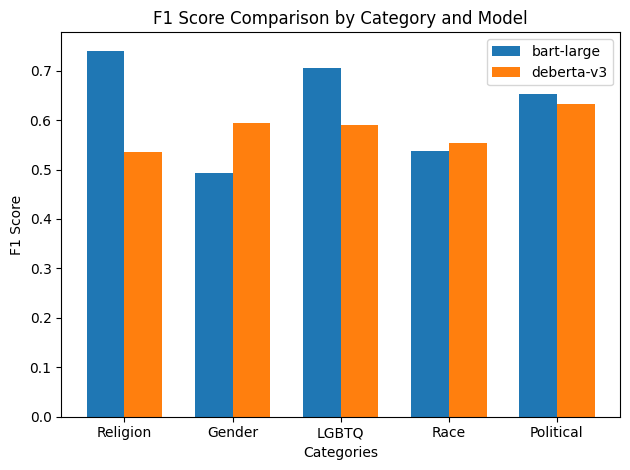

In [93]:

# List of categories
categories = ['Religion', 'Gender', 'LGBTQ', 'Race', 'Political']

# Accuracy results for BART and DeBERTa models
bart_results_f1_category = [bart_results_religion_accuracy['f1'], bart_results_gender_accuracy['f1'], bart_results_lgbtq_accuracy['f1'], bart_results_race_accuracy['f1'], bart_results_political_accuracy['f1']]
deberta_results_f1_category = [deberta_results_religion_accuracy['f1'], deberta_results_gender_accuracy['f1'], deberta_results_lgbtq_accuracy['f1'], deberta_results_race_accuracy['f1'], deberta_results_political_accuracy['f1']]

# Width of each bar
bar_width = 0.35

# Create a figure and axis
fig, ax = plt.subplots()

# Position of each bar group on the x-axis
x = range(len(categories))

# Plot the bars for BART and DeBERTa accuracy results
bart_bars = ax.bar(x, bart_results_f1_category, bar_width, label='bart-large')
deberta_bars = ax.bar([i + bar_width for i in x], deberta_results_f1_category, bar_width, label='deberta-v3')

# Set labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison by Category and Model')
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Old rationale results anaylsis

In [94]:

def get_accuracy_results_rationale(df):
  
  true_positive_bias = len(df[df.apply(lambda row: 'entailment' in row['predicted'] and row['bias'] == 'bias', axis=1)])
  false_positive_bias = len(df[df.apply(lambda row: 'entailment' in row['predicted'] and row['bias'] == 'neutral', axis=1)])
  false_negative_bias = len(df[df.apply(lambda row: ('neutral' in row['predicted'] or 'contradiction' in row['predicted']) and row['bias'] == 'bias', axis=1)])

  precision_bias = true_positive_bias / (true_positive_bias + false_positive_bias + 1e-10)  # Adding a small constant
  recall_bias = true_positive_bias / (true_positive_bias + false_negative_bias + 1e-10)  # Adding a small constant
  f1_bias = (2 * precision_bias * recall_bias) / (precision_bias + recall_bias + 1e-10)  # Adding a small constant

  true_positive_neutral = len(df[df.apply(lambda row: ('neutral' in row['predicted'] or 'contradiction' in row['predicted']) and row['bias'] == 'neutral', axis=1)])
  false_positive_neutral = len(df[df.apply(lambda row: ('neutral' in row['predicted'] or 'contradiction' in row['predicted']) and row['bias'] == 'bias', axis=1)])
  false_negative_neutral = len(df[df.apply(lambda row: 'entailment' in row['predicted'] and row['bias'] == 'neutral', axis=1)])

  precision_neutral = true_positive_neutral / (true_positive_neutral + false_positive_neutral + 1e-10)  # Adding a small constant
  recall_neutral = true_positive_neutral / (true_positive_neutral + false_negative_neutral + 1e-10)  # Adding a small constant
  f1_neutral = (2 * precision_neutral * recall_neutral) / (precision_neutral + recall_neutral + 1e-10)  # Adding a small constant

  return ({
    'precision': (precision_bias + precision_neutral) / 2,
    'recall': (recall_bias + recall_neutral) / 2,
    'f1': (f1_bias + f1_neutral) / 2,
    'accuracy': (true_positive_bias + true_positive_neutral) / len(df)

  })
    


In [95]:
get_accuracy_results_rationale(bart_large_rationale)

{'precision': 0.1508759291529367,
 'recall': 0.1529999999999694,
 'f1': 0.15170975048060326,
 'accuracy': 0.153}

In [96]:
get_accuracy_results_rationale(deberta_base_rationale)

{'precision': 0.11288013160062285,
 'recall': 0.11499999999997701,
 'f1': 0.11378677404378049,
 'accuracy': 0.115}

In [97]:
get_accuracy_results_rationale(deberta_v3_rationale)

{'precision': 0.5472304088262411,
 'recall': 0.529999999999894,
 'f1': 0.48283223073159265,
 'accuracy': 0.53}

### Breakdown of total neutral vs total bias predictions

In [98]:
def get_prediction_breakdown(df, threshold=1):

  # lower threshold for indexing issues
  threshold = threshold - 1

  # Count occurrences of 'bias' and 'neutral' predictions
  total_bias = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold], axis=1)])
  total_neutral = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold], axis=1)])

  return ({
    'Bias': total_bias,
    'Neutral':total_neutral
  })
    

print(get_prediction_breakdown(bart_results, 2))
print(get_prediction_breakdown(deberta_results, 1))



{'Bias': 3234, 'Neutral': 2230}
{'Bias': 3030, 'Neutral': 2434}


In [99]:
print(3234/(3234+2230))
print(2230/(3234+2230))

print(3030/(3030+2434))
print(2434/(3030+2434))


0.5918740849194729
0.4081259150805271
0.5545387994143485
0.44546120058565153
